# Import required packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings('ignore')

In [2]:
"""Load DataFrame"""
df=pd.read_csv('vehicles.csv')
df=pd.DataFrame(df)
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


In [3]:
"""Reindexing DataFrame so that price feature will at last"""
df= df.reindex(columns=['id', 'url', 'region', 'region_url', 'year', 'manufacturer',
       'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status',
       'transmission', 'vin', 'drive', 'size', 'type', 'paint_color',
       'image_url', 'description', 'county', 'state', 'lat', 'long','price'])

# 1) Removed Irrelevant features

In [4]:
df2=df.copy()
df2=df2.drop(columns=['url','region_url','vin','image_url','description','county','state'])
df2.head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,7222695916,prescott,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000
1,7218891961,fayetteville,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11900
2,7221797935,florida keys,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000
3,7222270760,worcester / central MA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500
4,7210384030,greensboro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4900


# 2) Dealing with missing values

In [5]:
df2.isnull().sum() #return series of columns with respective of number of null values


id                   0
region               0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
lat               6549
long              6549
price                0
dtype: int64

<Axes: >

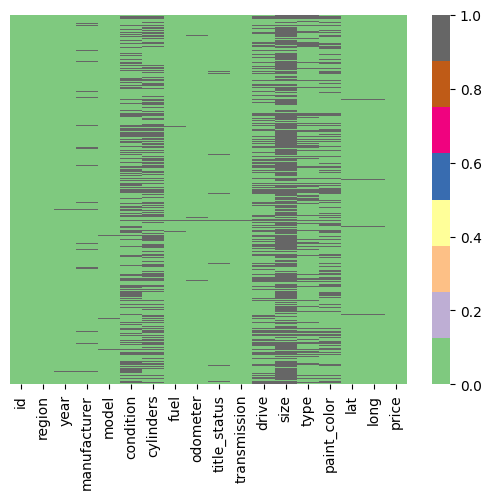

In [6]:
#heatmap to identify nulll values using graph
sns.heatmap(df2.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [7]:
#define numeric variable and categorical variable to work separatly on them
num_col=['year','odometer','lat','long']
cat_cols=['region','manufacturer','model','condition','cylinders','fuel','title_status','transmission','drive','size','type','paint_color']

# 2.1) Estimating better iterative imputer method

In [8]:
check_imputer=df2.copy()
check_imputer=check_imputer.drop(columns=['id'])

#object of LabelEncoder
encoder=preprocessing.LabelEncoder()

#function to label the categorical columns ignoring null values 
def encode(data):
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data
#loop to label each column or categorical values into numberic
for i in tqdm(range(len(cat_cols))):
    encode(check_imputer[cat_cols[i]])

100%|███████████████████████████████████████████| 12/12 [00:00<00:00, 19.49it/s]


In [9]:
check_imputer.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000
1,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11900
2,111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21000
3,396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500
4,131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4900


In [10]:
"""metrics which measure the distance between the model
and the data, like metrics. mean_squared_error ,
are available as neg_mean_squared_error
which return the negated value of the metric."""


'metrics which measure the distance between the model\nand the data, like metrics. mean_squared_error ,\nare available as neg_mean_squared_error\nwhich return the negated value of the metric.'

In [11]:
# Estimate the score on the entire dataset by filling missing values by mean and median

br_estimator = BayesianRidge() #base estimator
N_SPLITS = 6  #defining the cross-validation splitting strategy

score_simple_imputer = pd.DataFrame() #dataframe to store error of imputer
#computing MSE for mean and median
for strategy in ('mean', 'median'):
    X=check_imputer.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
    y = np.ravel(check_imputer.iloc[:,-1:])
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy),
        br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X, y, scoring='neg_mean_squared_error',
        cv=N_SPLITS
    )

In [12]:
# Estimate the score on the entire dataset by filling missing values by 4 different iterative imputer


#estimators for IterativeImputer
estimators = [
    BayesianRidge(),
    DecisionTreeRegressor(max_features='sqrt', random_state=0),
    ExtraTreesRegressor(n_estimators=10, random_state=0),
    KNeighborsRegressor(n_neighbors=15)
]
score_iterative_imputer = pd.DataFrame()
for esti in estimators:
        print("Estimating",esti.__class__.__name__)
        imputer = IterativeImputer(esti)
        df_new=check_imputer.copy()
        for col in check_imputer.columns:
            #col=check_imputer.columns[i]
            impute_data=imputer.fit_transform(df_new[col].values.reshape(-1,1))
            impute_data=impute_data.astype('int64')
            impute_data = pd.DataFrame(np.ravel(impute_data))
            df_new[col]=impute_data
        X=df_new.iloc[:,:-1]
        #y=check_imputer.iloc[:,-1:].values.ravel()
        y = np.ravel(df_new.iloc[:,-1:])
        score_iterative_imputer[esti.__class__.__name__] = cross_val_score(esti,X,y,scoring='neg_mean_squared_error',cv=6)

Estimating BayesianRidge
Estimating DecisionTreeRegressor
Estimating ExtraTreesRegressor
Estimating KNeighborsRegressor


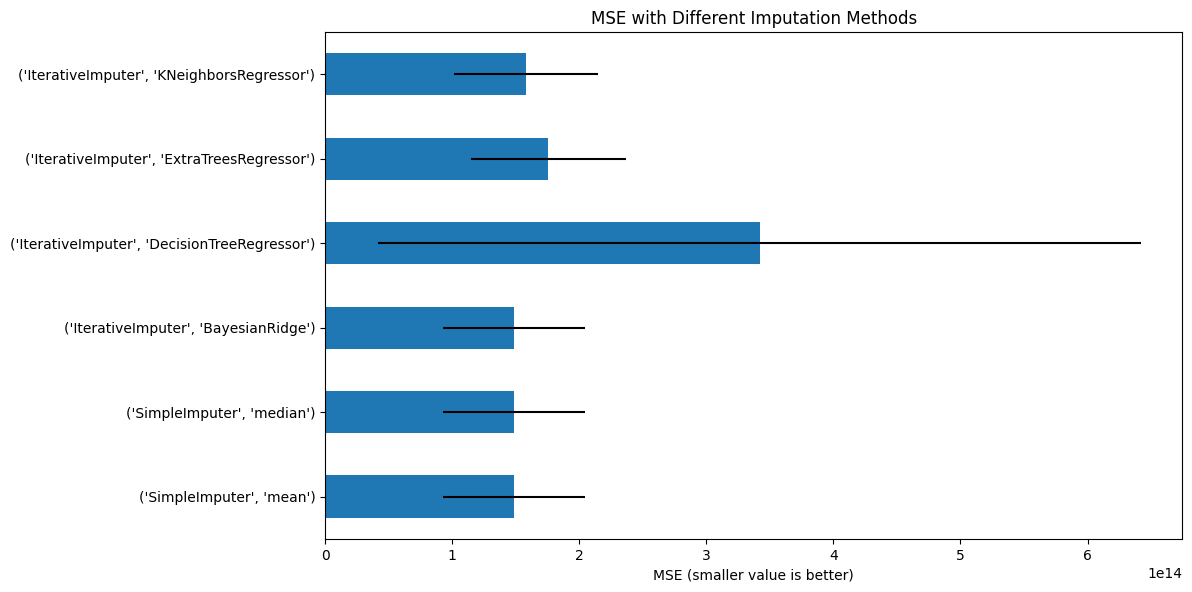

In [13]:
#ploting the graphs of scores each method
scores = pd.concat(
    [score_simple_imputer, score_iterative_imputer],
    keys=['SimpleImputer', 'IterativeImputer'], axis=1
)
fig, ax = plt.subplots(figsize=(12, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title('MSE with Different Imputation Methods')
ax.set_xlabel('MSE (smaller value is better)')
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels(means.index.tolist())
plt.tight_layout(pad=1)
plt.savefig('different-imputations-method',dpi=None)
plt.show()

## 2.2) Filling Numerical Missing Values i.e year & odometer

In [14]:
df2.isnull().sum()[num_col]

year        1205
odometer    4400
lat         6549
long        6549
dtype: int64

In [35]:
data_num=df2[num_col]
imputer_num=IterativeImputer(estimators[0]) #estimators[0] = BayesianRidge
impute_data=imputer_num.fit_transform(data_num)
df2[num_col]=impute_data

In [18]:
#Missing values after filling
df2.isnull().sum()[num_col]

year        0
odometer    0
lat         0
long        0
dtype: int64

## 2.4) Filling Categorical values

In [19]:
#Missing values before filling
df2.isnull().sum()[cat_cols]

region               0
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
title_status      8242
transmission      2556
drive           130567
size            306361
type             92858
paint_color     130203
dtype: int64

In [20]:
data_cat=df2[cat_cols]
encoder=preprocessing.LabelEncoder()

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(data_cat[columns])
    imputer = IterativeImputer(BayesianRidge())
    impute_data=imputer.fit_transform(data_cat[columns].values.reshape(-1, 1))
    impute_data=impute_data.astype('int64')
    impute_data = pd.DataFrame(impute_data)
    impute_data =encoder.inverse_transform(impute_data.values.reshape(-1, 1))
    data_cat[columns]=impute_data
df2[cat_cols]=data_cat    

In [21]:
#Missing values after filling
df2.isnull().sum()[cat_cols]

region          0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
dtype: int64

<Axes: >

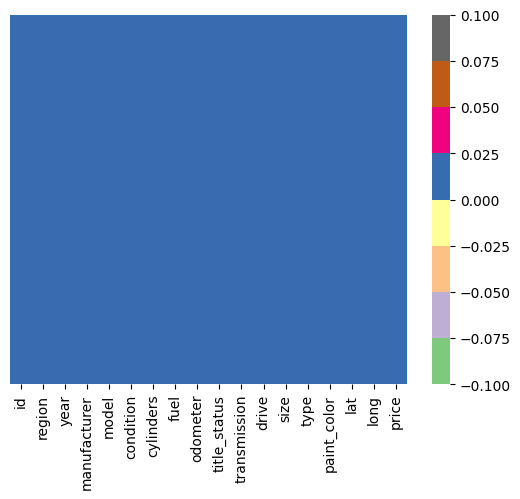

In [22]:
#Heat map tp check numm values visually
sns.heatmap(df2.isnull(),yticklabels=False,cbar=True,cmap='Accent')

In [23]:
#No null value in the dataset 
df2.isnull().sum()

id              0
region          0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
size            0
type            0
paint_color     0
lat             0
long            0
price           0
dtype: int64

In [24]:
df2.to_csv('vehiclesData.csv',index=False)

In [25]:
df2=pd.read_csv('vehiclesData.csv')

# 3) Outliers

In [26]:
from IPython.display import display,Latex
outliers_condi=Latex(r" $\textbf{W𝑒 𝑐𝑎𝑛 𝑠𝑎𝑦 $𝑥_1$ or $x_2$ 𝑖𝑠 𝑜𝑢𝑡𝑙𝑖𝑒𝑟𝑠 if }\\ x_1 < Q1 - 1.5*IQR \\ or\\ x_2 > Q3+1.5*IQR $")
outliers_info=Latex(r"$L_{p} = \frac{p}{100}(n+1) = i_p.f_p \\ where \,\, i_p \,\, is \,\, integer \,\, part \,\, of \,\, L_p \,\, and \,\, f_p \,\, is \,\, fractional \,\, part \,\, of \,\, L_p \\ Q1 = Y_{25} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ Q3 = Y_{75} = x_{i_p} + f_p*(x_{i_{p+1}}-x_{i_p}) \\ IQR = Q3-Q1 \\ x_1 = Q1 - 1.5*IQR \,\,and\,\, x_2 = Q3+1.5*IQR $")

In [27]:

display(outliers_info)
display(outliers_condi)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [28]:
#it will return the range of the variables and the values outside this range will be outliers
def outliers(arr,col):
    x=sorted(arr[col].values.ravel())
    L_25=25/100*(len(x)+1) #L_p where p=25%
    i_p=int(str(L_25).split(".")[0])
    f_p=int(str(L_25).split(".")[1])
    q1=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    L_75=75/100*(len(x)+1) #L_p where p=75%
    i_p=int(str(L_75).split(".")[0])
    f_p=int(str(L_75).split(".")[1])
    q3=x[i_p]+f_p*(x[i_p+1]-x[i_p])
    
    #q1,q3=(arr[col].quantile([0.25,0.75]))
    
    IQR=q3-q1
    x1=q1-1.5*IQR
    x2=q3+1.5*IQR
    return (x1,x2)

## 3.1) Price

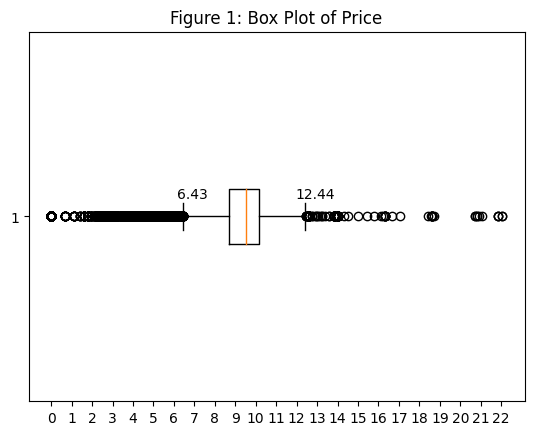

In [29]:
def min_max_price(df):
    r=[]
    q1,q3=(df['logprice'].quantile([0.25,0.75]))
    r.append(q1-1.5*(q3-q1))
    r.append(q3+1.5*(q3-q1))
    return (r)
df2['logprice'] = np.log(df2['price'])
x=df2['logprice']
price_range=list(range(0,int(max(df2['logprice']))+1))
red_square = dict(markerfacecolor='g', marker='s')
plt.boxplot(x, vert=False)
plt.xticks(price_range)
plt.text(min_max_price(df2)[0]-0.3,1.05,str(round(min_max_price(df2)[0],2)))
plt.text(min_max_price(df2)[1]-0.5,1.05,str(round(min_max_price(df2)[1],2)))
plt.title("Figure 1: Box Plot of Price")
plt.savefig('graph-boxplot-price.jpg')
plt.show()

## 3.2) Odometer

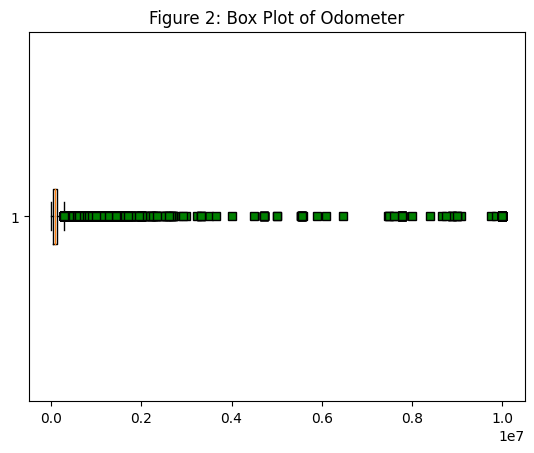

In [30]:
fig, ax1 = plt.subplots()
ax1.set_title('Figure 2: Box Plot of Odometer')
ax1.boxplot(df2['odometer'], vert=False, flierprops=red_square)
plt.savefig('graph-boxplot-odometer.jpg')
plt.show()

## 3.3) Year

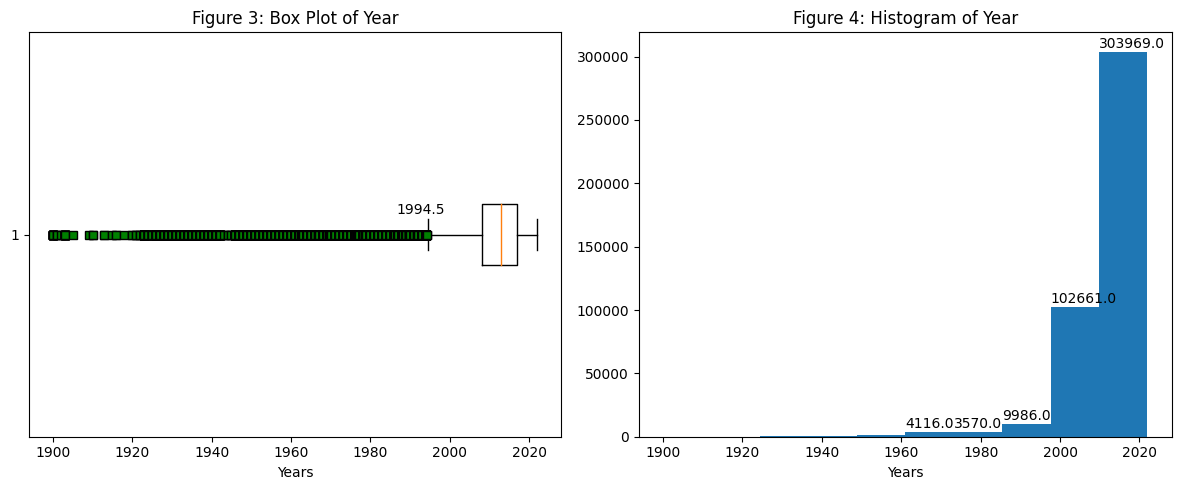

In [31]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(12,5))

#ploting boxplot
o1,o2=outliers(df2,'year')
ax1.boxplot(sorted(df2['year']), vert=False, flierprops=red_square)
ax1.set_xlabel("Years")
ax1.set_title("Figure 3: Box Plot of Year")
ax1.text(o1-8,1.05,str(round(o1,2)))

#ploting histogram
hist,bins=np.histogram(df2['year'])
n, bins, patches = ax2.hist(x=df2['year'], bins=bins)
ax2.set_xlabel("Years")
ax2.set_title("Figure 4: Histogram of Year")
for i in range(len(n)):
    if(n[i]>2000):
        ax2.text(bins[i],n[i]+3000,str(n[i]))

plt.tight_layout()
plt.savefig('graph-barplot-histogram-year.jpg',dpi=1200)
plt.show()

In [32]:

#removing outliers 
df_new=df2.copy()
out=np.array(['logprice','odometer','year'])
for col in out:
    o1,o2=outliers(df_new,col)
    df_new=df_new[(df_new[col]>=o1) & (df_new[col]<=o2)]
    print('IQR of',col,'=',o1,o2)
df_new=df_new[df_new['price']!=0]
df_new.drop('logprice',axis=1,inplace=True)

IQR of logprice = 6.430098455893903 12.43705625322699
IQR of odometer = -108470.5 282869.5
IQR of year = 1994.5 2030.5


In [33]:
df_new.head()

,id,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,lat,long,price
0,7222695916,prescott,2004.4,infiniti,g series,fair,5 cylinders,gas,20984.0,clean,automatic,4wd,full-size,offroad,grey,33.710686,-98.333734,6000
1,7218891961,fayetteville,2004.4,infiniti,g series,fair,5 cylinders,gas,20984.0,clean,automatic,4wd,full-size,offroad,grey,33.710686,-98.333734,11900
2,7221797935,florida keys,2004.4,infiniti,g series,fair,5 cylinders,gas,20984.0,clean,automatic,4wd,full-size,offroad,grey,33.710686,-98.333734,21000
3,7222270760,worcester / central MA,2004.4,infiniti,g series,fair,5 cylinders,gas,20984.0,clean,automatic,4wd,full-size,offroad,grey,33.710686,-98.333734,1500
4,7210384030,greensboro,2004.4,infiniti,g series,fair,5 cylinders,gas,20984.0,clean,automatic,4wd,full-size,offroad,grey,33.710686,-98.333734,4900


In [34]:
print("Shape before process=",df.shape)
print("Shape After process=",df_new.shape)
diff=df.shape[0]-df_new.shape[0]
print("Total {} rows and {} cols removed".format(diff,df.shape[1]-df_new.shape[1]))
df_new.to_csv("vehiclesFinal.csv",index=False)

Shape before process= (426880, 25)
Shape After process= (364429, 18)
Total 62451 rows and 7 cols removed
